In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
import tensorflow as tf
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, '/home/user/Downloads/proj/glove.6B/') # PRETRAINED MODEL GLoVE
TEXT_DATA_DIR = os.path.join(BASE_DIR, '/home/user/Downloads/proj/20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200 # very important factor
VALIDATION_SPLIT = 0.2

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, '/home/user/Downloads/proj/glove.6B/glove.6B.200d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]             # values[] varies
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(values)
print(word)
print(coefs)
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
['sandberger', '-0.51113', '-0.47518', '0.22871', '0.0086524', '-0.43737', '-0.28747', '0.23416', '-0.020332', '0.50697', '-0.24367', '-0.28646', '-0.024133', '-9.6845e-06', '0.048092', '-0.24467', '-0.12121', '0.13644', '-0.1619', '0.099349', '0.036545', '-0.031657', '-0.84172', '0.23022', '0.030332', '-0.67638', '-0.29399', '0.13298', '-0.037917', '-0.1097', '0.0026541', '-0.46669', '0.12329', '-0.0040373', '-0.28782', '-0.16733', '0.20938', '0.49163', '-0.060818', '0.14326', '-0.13628', '-0.1565', '-0.08306', '-0.08582', '-0.19864', '0.36016', '-0.16752', '-0.0064389', '0.23173', '-0.16636', '-0.1712', '0.184', '-0.52889', '-0.07044', '-0.37772', '-0.066473', '0.38519', '0.26262', '-0.039148', '-0.28182', '-0.16908', '-0.49491', '-0.14138', '0.41732', '-0.068889', '0.10125', '0.018499', '-0.066256', '0.19328', '-0.24784', '0.25005', '-0.063437', '0.26013', '0.2362', '-0.29019', '0.49803', '-0.74534', '0.2762', '0.16096', '-0.24558', '0.16969', '-0.11854', '0.7

In [4]:
# print os.path.join('cat','dog')              # 'cat/dog' no surprise here
# print os.path.join('cat','dog').join('fish') # 'fcat/dogicat/dogscat/dogh'

In [5]:
# second, prepare text samples and their labels

print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):     # sorted will directly sort the elements Another difference is that the list.sort() method is only defined for lists. 
                                                    #In contrast, the sorted() function accepts any iterable.
    path = os.path.join(TEXT_DATA_DIR, name) 
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


Pads sequences to the same length.

This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape  (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.

Sequences that are shorter than num_timesteps are padded with value at the end.

Sequences longer than num_timesteps are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.

Pre-padding is the default.

In [6]:
# finally, vectorize the text samples into a 2D integer tensor

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels)) #one hot encoding
#print(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


In [7]:
# split the data into a training set and a validation set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print(num_validation_samples)
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)

print('Preparing embedding matrix.')

3999
(15998, 1000) (3999, 1000) (15998, 20) (3999, 20)
Preparing embedding matrix.


In [8]:
# prepare embedding matrix

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [9]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed

#keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)

#Turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

## This layer can only be used as the first layer in a model.


embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

Training model.


In [10]:
tf.reset_default_graph()

In [11]:
# train a 1D convnet with global maxpooling

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

In [12]:
model.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['acc'])
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/20
15998/15998 [==============================] - 116s 7ms/step - loss: 2.3206 - acc: 0.2410 - val_loss: 1.8906 - val_acc: 0.3526
Epoch 2/20
15998/15998 [==============================] - 117s 7ms/step - loss: 1.3799 - acc: 0.5257 - val_loss: 1.1828 - val_acc: 0.5914
Epoch 3/20
15998/15998 [==============================] - 113s 7ms/step - loss: 1.0253 - acc: 0.6503 - val_loss: 1.0176 - val_acc: 0.6522
Epoch 4/20
15998/15998 [==============================] - 113s 7ms/step - loss: 0.8189 - acc: 0.7273 - val_loss: 0.9526 - val_acc: 0.6824
Epoch 5/20
15998/15998 [==============================] - 114s 7ms/step - loss: 0.6769 - acc: 0.7725 - val_loss: 1.0024 - val_acc: 0.6844
Epoch 6/20
15998/15998 [==============================] - 112s 7ms/step - loss: 0.5646 - acc: 0.8102 - val_loss: 1.0955 - val_acc: 0.6767
Epoch 7/20
15998/15998 [==============================] - 111s 7ms/step - loss: 0.4638 - acc: 0.8445 - val_loss: 0.8392 - v

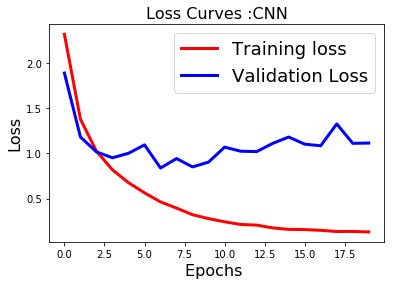

In [13]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

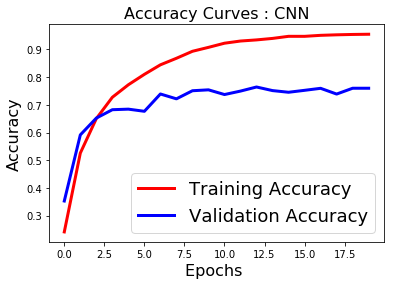

In [14]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()